
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.19?urlpath=lab/tree/analysis/3D/event_sampling.ipynb)
- You may download all the notebooks in the documentation as a
[tar file](../../../_downloads/notebooks-0.19.tar).
- **Source files:**
[event_sampling.ipynb](../../../_static/notebooks/event_sampling.ipynb) |
[event_sampling.py](../../../_static/notebooks/event_sampling.py)
</div>


# Event sampling

## Prerequisites 

To understand how to generate a Model and a MapDataset, and how to fit the data, please refer to the `~gammapy.modeling.models.SkyModel` and [simulate_3d](simulate_3d.ipynb).

## Context 

This tutorial describes how to sample events from an observation of a one (or more) gamma-ray source(s). The main aim of the tutorial will be to set the minimal configuration needed to deal with the Gammapy event-sampler and how to obtain an output photon event list.

The core of the event sampling lies into the Gammapy `~gammapy.datasets.MapDatasetEventSampler` class, which is based on the inverse cumulative distribution function [(Inverse CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Inverse_distribution_function_(quantile_function)). 

The `~gammapy.datasets.MapDatasetEventSampler` takes in input a `~gammapy.datasets.Dataset` object containing the spectral, spatial and temporal properties of the source(s) of interest.

The `~gammapy.datasets.MapDatasetEventSampler` class evaluates the map of predicted counts (`npred`) per bin of the given Sky model, and the `npred` map is then used to sample the events. In particular, the output of the event-sampler will be a set of events having information about their true coordinates, true energies and times of arrival. 

To these events, IRF corrections (i.e. PSF and energy dispersion) can also further applied in order to obtain reconstructed coordinates and energies of the sampled events. 

At the end of this process, you will obtain an event-list in FITS format. 

## Objective
Describe the process of sampling events from a given Sky model and obtaining an output event-list.

## Proposed approach

In this section, we will show how to define an observation and to create a Dataset object. These are both necessary for the event sampling. 
Then, we will define the Sky model from which we sample events. 

In this tutorial, we propose examples for sampling events of:

* [a point-like source](#sampling-the-source-and-background-events)
* [a time variable point-like source](#time-variable-source-using-a-lightcurve)
* [an extended source using a template map](#extended-source-using-a-template)
* [a set of observations](#simulate-mutiple-event-lists)

We will work with the following functions and classes:

* `~gammapy.data.Observations`
* `~gammapy.datasets.Dataset`
* `~gammapy.modeling.models.SkyModel`
* `~gammapy.datasets.MapDatasetEventSampler`
* `~gammapy.data.EventListgammapy.data.EventList`

## Setup 
As usual, let's start with some general imports...

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.estimators import LightCurveEstimator
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
)

### Define an Observation

You can firstly create a `gammapy.data.Observations` object that contains the pointing position, the GTIs and the IRF you want to consider. 

Hereafter, we chose the IRF of the South configuration used for the CTA DC1 and we set the pointing position of the simulated field at the Galactic Center. We also fix the exposure time to 1 hr.

Let's start with some initial settings:

In [3]:
filename = "$GAMMAPY_DATA/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"

pointing = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
livetime = 1 * u.hr

Now you can create the observation:

In [4]:
irfs = load_cta_irfs(filename)
observation = Observation.create(
    obs_id=1001, pointing=pointing, livetime=livetime, irfs=irfs
)

### Define the MapDataset

Let's generate the `~gammapy.datasets.Dataset` object (for more info on `~gammapy.datasets.Dataset` objects, please visit the [link](../../starting/analysis_2.ipynb#Preparing-reduced-datasets-geometry)): we define the energy axes (true and reconstruncted), the migration axis and the geometry of the observation. 

*This is a crucial point for the correct configuration of the event sampler. Indeed the spatial and energetic binning should be treaten carefully and... the finer the better. For this reason, we suggest to define the energy axes (true and reconstructed) by setting a minimum binning of least 10-20 bins per decade for all the sources of interest. The spatial binning may instead be different from source to source and, at first order, it should be adopted a binning significantly smaller than the expected source size.*

For the examples that will be shown hereafter, we set the geometry of the dataset to a field of view of 2degx2deg and we  bin the spatial map with pixels of 0.02 deg.

In [5]:
energy_axis = MapAxis.from_energy_bounds(
    "0.1 TeV", "100 TeV", nbin=10, per_decade=True
)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true"
)
migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra"
)

geom = WcsGeom.create(
    skydir=pointing,
    width=(2, 2),
    binsz=0.02,
    frame="galactic",
    axes=[energy_axis],
)

In the following, the dataset is created by selecting the effective area, background model, the PSF and the Edisp from the IRF. The dataset thus produced can be saved into a FITS file just using the `write()` function. We put it into the `evt_sampling` sub-folder:

In [6]:
%%time
empty = MapDataset.create(
    geom,
    energy_axis_true=energy_axis_true,
    migra_axis=migra_axis,
    name="my-dataset",
)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

Path("event_sampling").mkdir(exist_ok=True)
dataset.write("./event_sampling/dataset.fits", overwrite=True)

CPU times: user 846 ms, sys: 161 ms, total: 1.01 s
Wall time: 1.04 s


### Define the Sky model: a point-like source

Now let's define a Sky model (see how to create it [here](../../api/models.ipynb)) for a point-like source centered 0.5 deg far from the Galactic Center and with a power-law spectrum. We then save the model into a yaml file.

In [7]:
spectral_model_pwl = PowerLawSpectralModel(
    index=2, amplitude="1e-12 TeV-1 cm-2 s-1", reference="1 TeV"
)
spatial_model_point = PointSpatialModel(
    lon_0="0 deg", lat_0="0.5 deg", frame="galactic"
)

sky_model_pntpwl = SkyModel(
    spectral_model=spectral_model_pwl,
    spatial_model=spatial_model_point,
    name="point-pwl",
)

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

models = Models([sky_model_pntpwl, bkg_model])

file_model = "./event_sampling/point-pwl.yaml"
models.write(file_model, overwrite=True)

## Sampling the source and background events
<a id='sampling-the-source-and-background-events'></a>
Now, we can finally add the `~gammapy.modeling.models.SkyModel` we want to event-sample to the `~gammapy.datasets.Dataset` container:

In [8]:
dataset.models = models
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : point-pwl
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.000   +/-    0.00             
    amplitude               :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0                   :      0.000   +/-    0.00 deg         
    lat_0                   :      0.500   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :      1.000   +/-    0.00             
    tilt         (frozen)   :      0.000                   
    reference    (frozen)   :      1.000       TeV         




The next step shows how to sample the events with the `~gammapy.datasets.MapDatasetEventSampler` class. The class requests a random number seed generator (that we set with `random_state=0`), the `~gammapy.datasets.Dataset` and the `gammapy.data.Observations` object. From the latter, the `~gammapy.datasets.MapDatasetEventSampler` class takes all the meta data information.

In [9]:
%%time
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

CPU times: user 2.15 s, sys: 453 ms, total: 2.61 s
Wall time: 2.64 s


The output of the event-sampler is an event list with coordinates, energies (true and reconstructed) and time of arrivals of the source and background events. `events` is a `~gammapy.data.EventListgammapy.data.EventList` object (more details [here](https://docs.gammapy.org/dev/tutorials/data/cta.html#Events)).
Source and background events are flagged by the MC_ID identifier (where 0 is the default identifier for the background).

In [10]:
print(f"Source events: {(events.table['MC_ID'] == 1).sum()}")
print(f"Background events: {(events.table['MC_ID'] == 0).sum()}")

Source events: 138
Background events: 15319


We can inspect the properties of the simulated events as follows:

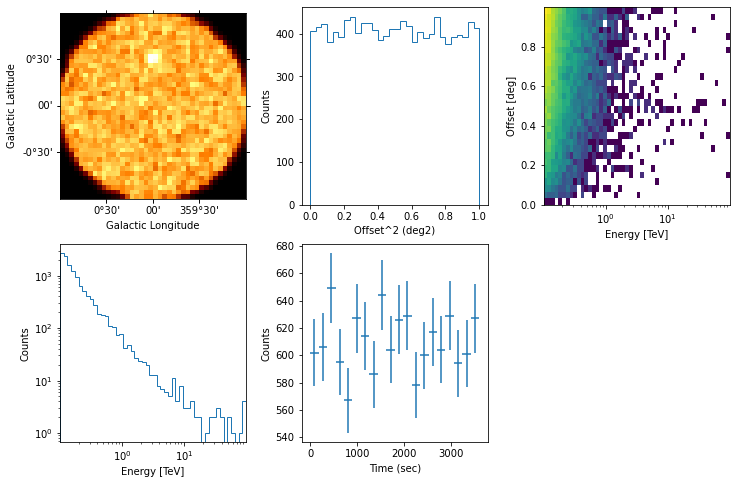

In [11]:
events.select_offset([0, 1] * u.deg).peek()

By default, the `~gammapy.datasets.MapDatasetEventSampler` fills the metadata keyword `OBJECT` in the event list using the first model of the SkyModel object. You can change it with the following commands:

In [12]:
events.table.meta["OBJECT"] = dataset.models[0].name

Let's write the event list and its GTI extension to a FITS file. We make use of `fits` library in `astropy`:

In [13]:
primary_hdu = fits.PrimaryHDU()
hdu_evt = fits.BinTableHDU(events.table)
hdu_gti = fits.BinTableHDU(dataset.gti.table, name="GTI")
hdu_all = fits.HDUList([primary_hdu, hdu_evt, hdu_gti])
hdu_all.writeto("./event_sampling/events_0001.fits", overwrite=True)

### Generate a skymap
A skymap of the simulated events can be obtained with:

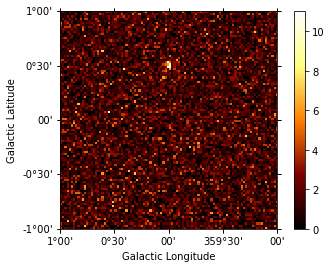

In [14]:
counts = Map.from_geom(geom)

counts.fill_events(events)
counts.sum_over_axes().plot(add_cbar=True);

### Fit the simulated data
We can now check the sake of the event sampling by fitting the data (a tutorial of source fitting is [here](../../starting/analysis_2.ipynb#Fit-the-model) and [here](simulate_3d.ipynb). We make use of the same `~gammapy.modeling.models.Models` adopted for the simulation. 
Hence, we firstly read the `~gammapy.datasets.Dataset` and the model file, and we fill the `~gammapy.datasets.Dataset` with the sampled events. We set the `counts` map to the `dataset`:

In [15]:
models_fit = Models.read("./event_sampling/point-pwl.yaml")

dataset.counts = counts
dataset.models = models_fit

Let's fit the data and look at the results:

In [16]:
%%time
fit = Fit()
result = fit.run(dataset)
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 102
	total stat : 76401.38

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 102
	total stat : 76401.38


CPU times: user 8.88 s, sys: 1.71 s, total: 10.6 s
Wall time: 10.4 s


The results looks great!

## Time variable source using a lightcurve
<a id='time-variable-source-using-a-lightcurve'></a>
The event sampler can also handle temporal variability of the simulated sources. In this example, we show how 
to sample a source characterized by an exponential decay, with decay time of 2800 seconds, during the observation. 

First of all, let's create a lightcurve:

In [17]:
t0 = 2800 * u.s
t_ref = Time("2000-01-01T00:01:04.184")

times = t_ref + livetime * np.linspace(0, 1, 100)
expdecay_model = ExpDecayTemporalModel(t_ref=t_ref.mjd * u.d, t0=t0)

where we defined the time axis starting from the reference time `t_ref` up to the requested exposure (`livetime`). The bin size of the time-axis is quite arbitrary but, as above for spatial and energy binnings, the finer the better.

Then, we can create the sky model. Just for the sake of the example, let's boost the flux of the simulated source of an order of magnitude:

In [18]:
spectral_model_pwl.amplitude.value = 2e-11

sky_model_pntpwl = SkyModel(
    spectral_model=spectral_model_pwl,
    spatial_model=spatial_model_point,
    temporal_model=expdecay_model,
    name="point-pwl",
)

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

models = Models([sky_model_pntpwl, bkg_model])

file_model = "./event_sampling/point-pwl_decay.yaml"
models.write(file_model, overwrite=True)

For simplicity, we use the same dataset defined for the previous example:

In [19]:
dataset.models = models
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : point-pwl
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : ExpDecayTemporalModel
  Parameters:
    index                   :      2.000   +/-    0.00             
    amplitude               :   2.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0                   :      0.000   +/-    0.00 deg         
    lat_0                   :      0.500   +/-    0.00 deg         
    t0                      :   2800.000   +/-    0.00 s           
    t_ref        (frozen)   :  51544.001       d           

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :      1.000   +/-    0.00          

And now, let's simulate the variable source:

In [20]:
%%time
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

CPU times: user 1.94 s, sys: 385 ms, total: 2.33 s
Wall time: 2.33 s


In [21]:
print(f"Source events: {(events.table['MC_ID'] == 1).sum()}")
print(f"Background events: {(events.table['MC_ID'] == 0).sum()}")

Source events: 1523
Background events: 15246


We can now inspect the properties of the simulated source. To do that, we adopt the `select_region` function that extracts only the events into a given `SkyRegion` of a `~gammapy.data.event_list.EventList` object:

In [22]:
src_position = SkyCoord(0.0, 0.5, frame="galactic", unit="deg")

on_region_radius = Angle("0.15 deg")
on_region = CircleSkyRegion(center=src_position, radius=on_region_radius)

src_events = events.select_region(on_region)

Then we can have a quick look to the data with the `peek` function:

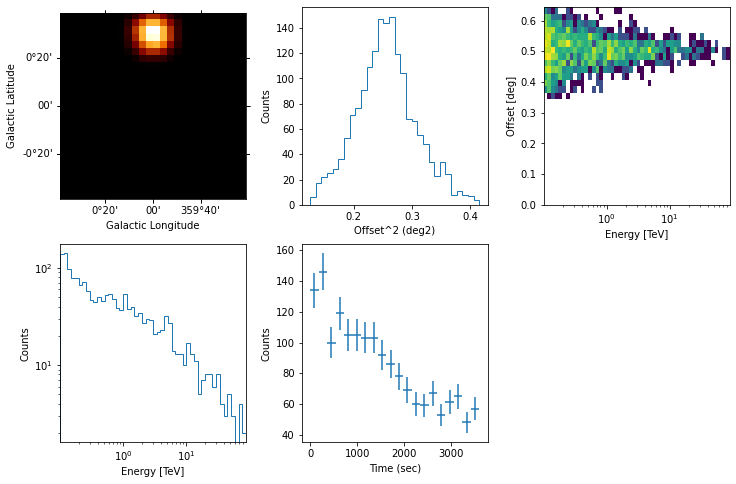

In [23]:
src_events.peek()

In the right figure of the bottom panel, it is shown the source lightcurve that follows a decay trend as expected.

## Extended source using a template
<a id='extended-source-using-a-template'></a>
The event sampler can also work with a template model.
Here we use the interstellar emission model map of the Fermi 3FHL, which can be found in the GAMMAPY data repository.

We proceed following the same steps showed above and we finally have a look at the event's properties:

In [24]:
template_model = TemplateSpatialModel.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz", normalize=False
)
# we make the model brighter artificially so that it becomes visible over the background
diffuse = SkyModel(
    spectral_model=PowerLawNormSpectralModel(norm=5),
    spatial_model=template_model,
    name="template-model",
)

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

models_diffuse = Models([diffuse, bkg_model])

file_model = "./event_sampling/diffuse.yaml"
models_diffuse.write(file_model, overwrite=True)

Template file already exits, and overwrite is False


In [25]:
dataset.models = models_diffuse
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : template-model
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                    :      5.000   +/-    0.00             
    tilt         (frozen)   :      0.000                   
    reference    (frozen)   :      1.000       TeV         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :      1.000   +/-    0.00             
    tilt         (frozen)   :      0.000                   
    reference    (frozen)   :      1.000       TeV         




In [26]:
%%time
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

CPU times: user 3.91 s, sys: 764 ms, total: 4.67 s
Wall time: 4.41 s


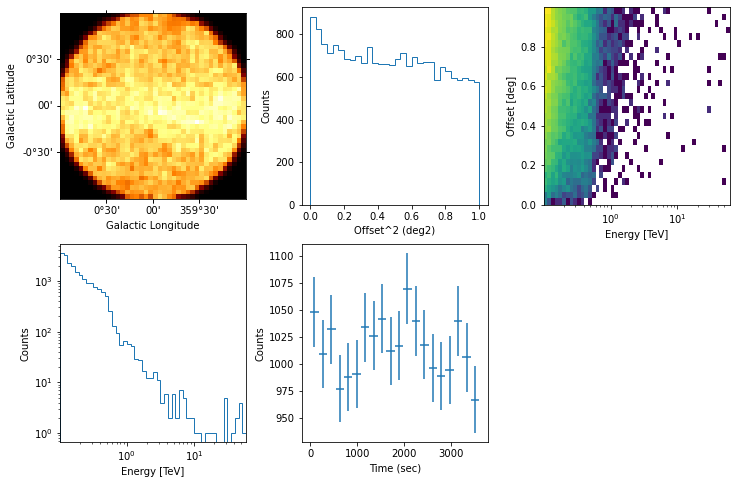

In [27]:
events.select_offset([0, 1] * u.deg).peek()

## Simulate multiple event lists
<a id='simulate-mutiple-event-lists'></a>
In some user case, you may want to sample events from a number of observations. 
In this section, we show how to simulate a set of event lists. For simplicity we consider only one point-like source, observed three times for 1 hr and assuming the same pointing position.

Let's firstly define the time start and the livetime of each observation:

In [28]:
tstarts = [1, 5, 7] * u.hr
livetimes = [1, 1, 1] * u.hr

In [29]:
%%time
for idx, tstart in enumerate(tstarts):

    observation = Observation.create(
        obs_id=idx,
        pointing=pointing,
        tstart=tstart,
        livetime=livetimes[idx],
        irfs=irfs,
    )

    dataset = maker.run(empty, observation)
    dataset.models = models

    sampler = MapDatasetEventSampler(random_state=idx)
    events = sampler.run(dataset, observation)
    events.table.write(
        f"./event_sampling/events_{idx:04d}.fits", overwrite=True
    )

CPU times: user 7.48 s, sys: 1.46 s, total: 8.94 s
Wall time: 8.64 s


You can now load the event list with `Datastore.from_events_files()` and make your own analysis following the instructions in the [`analysis_2`](analysis_2.ipynb) tutorial.

In [30]:
path = Path("./event_sampling/")
paths = list(path.rglob("events*.fits"))
data_store = DataStore.from_events_files(paths)
data_store.obs_table

OBS_ID,TSTART,TSTOP,ONTIME,LIVETIME,DEADC,TELESCOP,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
,s,s,s,s,,,deg,deg,deg,deg,,,,,,,,,,
int64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,str13,str13,str13,str13,str1,str9,str13,str13,str31,int64
2,25199.99999979045,28800.00000020955,3600.0,3600.0,1.0,CTA,266.4049882865447,-28.93617776179147,0.0,4.4527765540489235e-14,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,point-pwl,NOT AVAILABLE,NOT AVAILABLE,event_sampling/events_0002.fits,15133
0,3599.999999790452,7200.000000209548,3600.0,3600.0,1.0,CTA,266.4049882865447,-28.93617776179147,0.0,4.4527765540489235e-14,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,point-pwl,NOT AVAILABLE,NOT AVAILABLE,event_sampling/events_0000.fits,15627
1,18000.00000020955,21600.0,3600.0,3600.0,1.0,CTA,266.4049882865447,-28.93617776179147,0.0,4.4527765540489235e-14,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,point-pwl,NOT AVAILABLE,NOT AVAILABLE,event_sampling/events_0001.fits,15226


For completeness, `data_store` is a `~gammapy.data.Datastore` object. You can find more information about it [here](https://docs.gammapy.org/dev/tutorials/data/cta.html#Datastore).

<!-- ## Read simulated event lists with Datastore.from_events_lists
Here we show how to simulate a set of event lists of the same Sky model, but with different GTIs. We make use of the settings we applied previously.
Let's define the GTI firstly, choosing a time start and a duration of the observation: -->

## Exercises
- Try to sample events for an extended source (e.g. a radial gaussian morphology);
- Change the spatial model and the spectrum of the simulated Sky model;
- Include a temporal model in the simulation